# Spectral Clustering

### Project members:
Mengshu Shao, Yelena Kernogitski

### GitHub Repositories: 
https://github.com/yelenakernogitski/Spectral-Clustering-Project

## Abstract
Clustering is one of the building blocks in modern data analysis, and has been widely used in machine learning and pattern recognition. Two commonly used approaches are K-means and learning a mixture model using EM. However, these methods have some drawbacks, such as violation of the harsh simplifying assumption which the density of each cluster is Gaussian. One method that provides a possible solution in finding useful clusters is spectral clustering, which utilizes eigenvectors derived from the distance between points. The method performs dimensionality reduction in order to find clusters. In this report, First we implement a simple spectral clustering algorithm for clustering points in . Second we analyze how it works in “ideal” case in which the points are exactly far apart (i.e., when affinity matrix s strictly block diagonal), and in general case in which affinity’s off-diagonal blocks are non-zero. Then we test the algorithm by applying it to a number of challenging clustering problems. Further, we attempt to optimize the algorithm using within-Python options (such as vectorization) in addition to JIT and Cython wrapping functions. Finally, we compare the original method in Python and the latter, higher performance method by determining the efficiency of each method. 


## Introduction

A significant aim of machine learning and pattern recognition is finding appropriate clusters that are able to accurately classify data points. Two standard approaches used in clustering are K-means and Expectation-Maximazation which allow for learning a mixture model. The latter has severe drawbacks where we must estimate the density of each cluster to be Gaussian due to parametric assumptions, and the log likelihood may result in getting caught in a local minima, and many various initial values may need to be used [1]. K-means clustering by itself leads to other problems, such as not being able to accomodate non-spherical data, and other complex datasets. A method that provides a possible solution in finding useful clusters in spectral clustering, which utilizes eigenvectors derived from the distance between points. An additional part of our algorithm uses the eigenvectors found in K-means clustering, as opposed to using the original dataset found. It has been found in empirical studies that the latter method is more accurate in classifying clusters [1]. In this report, we first implement a simple spectral clustering algorithm for clustering point in $\mathbb{R}^n$. Second, we analyze how it works in an "ideal" case in which the points are exactly far apart. Then we apply the algorithm to a number of challenging clustering problems. We will attempt to optimize our algorithm by using various methods--such as vectorization, JIT, and cython wrapping funcions. 

## Spectral Clustering Algorithm

Our algorithm has been previously described in (Ng et al, 2002). Provided a set of points $S= {s_1,...,s_n}$ in $\mathbb{R}^l$ that we want to clsuter into $k$ subsets:

1. Define the affinity matrix $A$ $\mathbb{R}^{nxn}$ by $A_{ij}=exp(-||s_i-s_j||^2 / 2\sigma^2)$ if $i\neq{j}$, and $A_{ii}=0$.
    
2. Create a diagonal matrix whose ($i$,$i$) element is the sum of $A's$ i-th row, and construct L, where $L= D^{-1/2}AD^{-1/2}$.
    
3. Find ${x_1,...,x_n}$, the $k$ largest eigenvectors of $L$, and create the matrix $X$, by placing the k eigenvectors in columns.
    
4. Use $X$ to form the matrix $Y$, by normalizing each X's rows to have unit length (i.e. $Y_{ij}=X_{ij}/(\sum_{j}{}X_{ij}^2)^{1/2}$). 
    
5. Treating each row of $Y$ as a point in $\mathbb{R}^k$, cluster into $k$ clusters using K-means
    
6. Assign the original point $s_i$ to cluster $j$ if row $i$ of the matrix $Y$ was assigned to cluster $j$. 

Our scaling parameter $\sigma^2$ was found by minimizing the distortion of the Y matrix and the clustering centers that correspond to each assigned cluster. The distortion was found by summing over the Euclidean distances between each data point and the center of its assigned cluster. We found $\sigma^2$ by using an iterative procedure to find which value of $\sigma^2$ minimized the distortion. Generally, $\sigma^2$ can be determined using human input, but this process automizes the procedure. 

### Algorithm

Firstly, we'll illustrate the algorithm step by step on a simple matrix.

In [2]:
import numpy as np
import scipy.linalg as la
from numpy.core.umath_tests import inner1d
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from matplotlib import pyplot as plt
from more_itertools import unique_everseen
import numba
from numba import *
import time

Our simple example

In [3]:
s = np.array([[2,1], [3,4], [5,4]])
s

array([[2, 1],
       [3, 4],
       [5, 4]])

#### Form the affinity matrix

In [3]:
n = np.shape(s)[0]
def affinity(s, var):
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            A[i, i] = 0
            A[i,j] = np.exp(-(la.norm(s[i] - s[j])**2) / (2*var))
    return A

A=affinity(s,1)

#### Define D and L

In [4]:
D = np.zeros((n, n))
for i in range(n):
    D[i, i] = 1 / (A[i].sum())
D

array([[ 145.74376886,    0.        ,    0.        ],
       [   0.        ,    7.03862366,    0.        ],
       [   0.        ,    0.        ,    0.88070135]])

In [5]:
L = np.sqrt(D).dot(A).dot(np.sqrt(D))
L

array([[ 0.        ,  0.21580746,  0.00139817],
       [ 0.21580746,  0.        ,  0.33695293],
       [ 0.00139817,  0.33695293,  0.88070135]])

#### Find the k largest eigenvectors of L

In [6]:
value, vector = la.eig(L)

In [7]:
idx = np.argsort(value)[::-1]
value = value[idx]
vector = vector[:, idx]
value

array([ 1.00000000+0.j,  0.15099607+0.j, -0.27029472+0.j])

In [8]:
idx2 = np.array([1,0,2])
value2=value[idx2]
value2

array([ 0.15099607+0.j,  1.00000000+0.j, -0.27029472+0.j])

In [9]:
k = 2
X = vector[:, 0:k]
X

array([[ 0.07308967,  0.79087251],
       [ 0.33258841,  0.5550276 ],
       [ 0.94023553, -0.25780813]])

#### Form the matrix Y

In [10]:
Y = X / np.sum(X, 1)[:, np.newaxis]
Y

array([[ 0.08459823,  0.91540177],
       [ 0.37469853,  0.62530147],
       [ 1.37778103, -0.37778103]])

#### K-means clustering

In [11]:
def kmeans(y, k, max_iter=10):
    idx = np.random.choice(len(y), k, replace=False)
    idx_data = y[idx]
    for i in range(max_iter):
        dist = np.array([inner1d(y-c, y-c) for c in idx_data])
        clusters = np.argmin(dist, axis=0)
        idx_data = np.array([y[clusters==i].mean(axis=0) for i in range(k)])
    return (clusters, idx_data)

In [12]:
clusters,data=kmeans(Y, 2, max_iter=10)

#### Assign the original point S to clusters

In [13]:
dat=np.concatenate((s, clusters.reshape((3,1))), axis = 1)

In [14]:
s=pd.DataFrame(s)
s['cluster'] = clusters
b=pd.DataFrame(data)
cluster=range(len(b))
b['cluster']=cluster
x=pd.merge(s, b, on='cluster', how='outer')
c=x.ix[:,0:s.shape[1]-1] 
c=np.array(c)
d=x.ix[:,s.shape[1]:x.shape[1]]
d=np.array(d)

In [15]:
def dist(x,y):   
    return np.sum((x-y)**2)

#dist(c[0],d[0])
#allz=[]
#for i in range(0,len(x)):
#    allz.append(dist(c[i],d[i]))
#sum(allz)

#### Find the best $\sigma^2$

In [16]:
def affinity(s, var):
    n = np.shape(s)[0]
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            A[i, i] = 0
            A[i,j] = np.exp(-(la.norm(s[i] - s[j])**2) / (2*var))
    return A

def kmeans(y, k, max_iter=100):
    idx = np.random.choice(len(y), k, replace=False)
    idx_data = y[idx]
    for i in range(max_iter):
        dist = np.array([inner1d(y-c, y-c) for c in idx_data])
        clusters = np.argmin(dist, axis=0)
        idx_data = np.array([y[clusters==i].mean(axis=0) for i in range(k)])
    return (clusters, idx_data)


def findbestvar(s,vari,k):                  #to find best variance
    n = np.shape(s)[0]
    dis=[]
    for j in range(len(vari)):
        var=vari[j]
        A=affinity(s,var)
        D = np.zeros((n, n))
        for i in range(n):
            D[i, i] = 1 / (A[i].sum())

        L = np.sqrt(D).dot(A).dot(np.sqrt(D))

        value, vector = la.eig(L)

        idx = np.argsort(value)[::-1]
        value = value[idx]
        vector = vector[:, idx]

        X = vector[:, 0:k]
        Y = X / np.sum(X, 1)[:, np.newaxis]

        clusters,data=kmeans(Y, k, max_iter=100)

        snew=pd.DataFrame(s)
        snew['cluster'] = clusters
        b=pd.DataFrame(data)
        cluster=list(unique_everseen(clusters))
        b['cluster']=cluster
        x=pd.merge(snew, b, on='cluster', how='outer')
        c=x.ix[:,0:snew.shape[1]-1] 
        c=np.array(c)
        d=x.ix[:,snew.shape[1]:x.shape[1]]
        d=np.array(d)
        distance=dist(c,d)

        dis.append(distance)
    
    bestvar=np.argmin(dis)
    return(vari[bestvar])


In [17]:
def finalclustering(s,k,var):
    n = np.shape(s)[0]
    A=affinity(s,var)
    D = np.zeros((n, n))
    for i in range(n):
        D[i, i] = 1 / (A[i].sum())

    L = np.sqrt(D).dot(A).dot(np.sqrt(D))

    value, vector = la.eig(L)

    idx = np.argsort(value)[::-1]
    value = value[idx]
    vector = vector[:, idx]

    X = vector[:, 0:k]
    Y = X / np.sum(X, 1)[:, np.newaxis]

    clusters,data=kmeans(Y, k, max_iter=10)
    final=np.concatenate((s, clusters.reshape((len(clusters),1))), axis = 1)
    return(final,data,clusters)

In [18]:
s = np.array([[2,1], [3,4], [5,4]]) 

vari= np.linspace(.01, 4, 1000)
k = 2
bestvariance=findbestvar(s,vari,k)

In [19]:
bestvariance

0.83276276276276284

In [20]:
finalclustering(s,k,var=bestvariance)

x,y,z=finalclustering(s,k,var=bestvariance)
print(x)
print(y)
print(z)

[[2 1 1]
 [3 4 1]
 [5 4 0]]
[[ 1.27515835 -0.27515835]
 [ 0.19037481  0.80962519]]
[1 1 0]


### Test algorithm on "ideal" datasets

In [21]:
#num = 50
#s = np.random.multivariate_normal([7,9], [[3, 5],[3, 5]], 25)
#s2 = np.random.multivariate_normal([15,19], [[3, 5],[3, 5]], 25)
#s = np.array([[2,1], [3,4], [5,4]])
#s=np.concatenate((s, s2), axis=0)

from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs


batch_size = 50
centers = [[5, 5], [10, 10]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=50, centers=centers, cluster_std=0.7)

s=X


In [23]:
vari= np.linspace(0.01, 10, 100)
k = 2
bestvariance=findbestvar(s,vari,k)

In [24]:
final,centers,clusters=finalclustering(s,k,var=bestvariance)

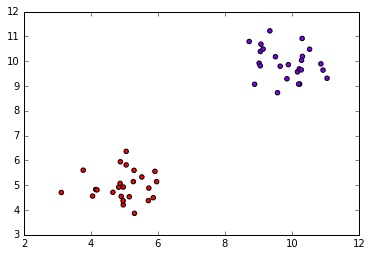

In [25]:
import matplotlib.cm as cm
fig, ax = plt.subplots()
ax.scatter(final[:,0],final[:,1],c=final[:,2],cmap=cm.rainbow)
pass

### Test algorithm on challenging clustering problems

In [21]:
### creating challenging datasets

from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler


n_samples = 50
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

datasets = [noisy_circles, noisy_moons, blobs, no_structure]
s,y=datasets[0]


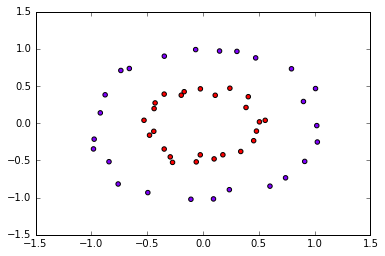

In [35]:
vari= np.linspace(0.01, 10, 1000)
k = 2
bestvariance=findbestvar(s,vari,k)
final,centers,clusters=finalclustering(s,k,var=bestvariance)
fig, ax = plt.subplots()
ax.scatter(final[:,0],final[:,1],c=final[:,2],cmap=cm.rainbow)
pass

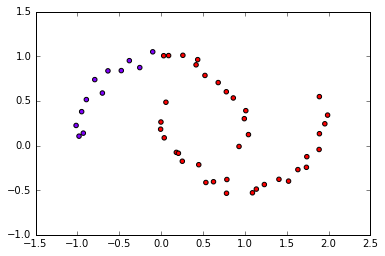

In [38]:
s,y=datasets[1]
vari= np.linspace(0.01, 10, 1000)
k = 2
bestvariance=findbestvar(s,vari,k)
final,centers,clusters=finalclustering(s,k,var=bestvariance)
fig, ax = plt.subplots()
ax.scatter(final[:,0],final[:,1],c=final[:,2],cmap=cm.rainbow)
pass

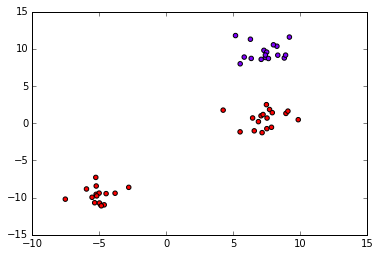

In [37]:
s,y=datasets[2]
vari= np.linspace(.3, 20, 1000)
k = 2
bestvariance=findbestvar(s,vari,k)
final,centers,clusters=finalclustering(s,k,var=bestvariance)
fig, ax = plt.subplots()
ax.scatter(final[:,0],final[:,1],c=final[:,2],cmap=cm.rainbow)
pass

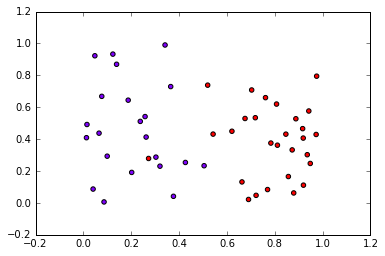

In [39]:
s,y=datasets[3]
vari= np.linspace(0.01, 10, 100)
k = 2
bestvariance=findbestvar(s,vari,k)
final,centers,clusters=finalclustering(s,k,var=bestvariance)
fig, ax = plt.subplots()
ax.scatter(final[:,0],final[:,1],c=final[:,2],cmap=cm.rainbow)
pass

## References

#### 1. Ng, Andrew Y., Michael I. Jordan, and Yair Weiss. "On spectral clustering: Analysis and an algorithm." Advances in neural information processing systems 2 (2002): 849-856.